In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import itertools

from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

sys.path.append("..")
from utils import metrics
from utils.data import TimeFusionDataset
from timefusion import TimeFusion
from utils.early_stopper import EarlyStopper

In [2]:
# Import data
train_data = pd.read_csv("../../datasets/electricity/train.csv").set_index("date")
test_data = pd.read_csv("../../datasets/electricity/test.csv").set_index("date")
train_data = train_data.iloc[:,:90]
test_data = test_data.iloc[:,:90]

# Normalize the signal power of each column
stds = train_data.std()
train_data /= stds
test_data /= stds

In [3]:
# Compute device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [4]:
context_length = 96
prediction_length = 24

# Create datasets
train_dataset = TimeFusionDataset(
    data = train_data.iloc[:int(0.9*len(train_data))],
    context_length = context_length,
)
train_dataset.add_timestamp_encodings()

val_dataset = TimeFusionDataset(
    data = train_data.iloc[int(0.9*len(train_data)):],
    context_length = context_length,
)
val_dataset.add_timestamp_encodings()

test_dataset = TimeFusionDataset(
    data = test_data,
    context_length = context_length,
)
test_dataset.add_timestamp_encodings()

train_loader = DataLoader(
    dataset = train_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
)

val_loader = DataLoader(
    dataset = val_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
)

In [5]:
predictor = TimeFusion(
    input_size = train_dataset.data.shape[1],
    output_size = train_data.shape[1],
    rnn_layers = 2,
    rnn_hidden = 60,
    autoencoder_layers = 2,
    autoencoder_latent = 400,
    scaling = True,
    device = device
)

print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

/rds/general/user/ejh19/home/Final-Year-Project/TimeFusion/examples/../utils/diffusion.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


Number of trainable parameters: 230560


In [6]:
predictor.modules

<bound method Module.modules of TimeFusion(
  (scaler): MeanScaler()
  (epsilon_theta): EpsilonTheta(
    (embedding): DiffusionEmbedding(
      (projection1): Linear(in_features=32, out_features=60, bias=True)
      (tanh1): Tanh()
      (projection2): Linear(in_features=60, out_features=60, bias=True)
    )
    (rnn): LSTM(98, 60, num_layers=2, batch_first=True)
    (autoencoder): Sequential(
      (0): Linear(in_features=150, out_features=150, bias=True)
      (1): ResidualBlock(
        (linear1): Linear(in_features=150, out_features=100, bias=True)
        (relu): ReLU()
        (linear2): Linear(in_features=100, out_features=150, bias=True)
        (tanh): Tanh()
      )
      (2): ResidualBlock(
        (linear1): Linear(in_features=150, out_features=100, bias=True)
        (relu): ReLU()
        (linear2): Linear(in_features=100, out_features=150, bias=True)
        (tanh): Tanh()
      )
      (3): ResidualBlock(
        (linear1): Linear(in_features=150, out_features=100, bia

In [7]:
optimizer = torch.optim.Adam(params=predictor.parameters(),lr=4e-4)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=120)

predictor.train_network(
    train_loader = train_loader,
    epochs=120,
    val_loader = val_loader,
    val_metrics= {
        "Val MAE": nn.L1Loss(),
    },
    optimizer = optimizer,
    lr_scheduler= lr_scheduler,
    early_stopper=EarlyStopper(patience=20),
    save_weights = True,
    weight_folder = "weights/electricity"
)

Epoch: 1/120: 100%|██████████| 169/169 [00:02<00:00, 77.13batch/s, Training loss=0.7314]


Val MAE: 0.5725 , val_loss: 0.5249 , 


Epoch: 2/120: 100%|██████████| 169/169 [00:02<00:00, 77.25batch/s, Training loss=0.4219]


Val MAE: 0.4562 , val_loss: 0.3516 , 


Epoch: 3/120: 100%|██████████| 169/169 [00:02<00:00, 76.69batch/s, Training loss=0.3052]


Val MAE: 0.3996 , val_loss: 0.2889 , 


Epoch: 4/120: 100%|██████████| 169/169 [00:02<00:00, 74.57batch/s, Training loss=0.2468]


Val MAE: 0.3522 , val_loss: 0.2342 , 


Epoch: 5/120: 100%|██████████| 169/169 [00:02<00:00, 74.34batch/s, Training loss=0.2211]


Val MAE: 0.3404 , val_loss: 0.2260 , 


Epoch: 6/120: 100%|██████████| 169/169 [00:02<00:00, 74.29batch/s, Training loss=0.2131]


Val MAE: 0.3316 , val_loss: 0.2202 , 


Epoch: 7/120: 100%|██████████| 169/169 [00:02<00:00, 73.13batch/s, Training loss=0.1999]


Val MAE: 0.3244 , val_loss: 0.2128 , 


Epoch: 8/120: 100%|██████████| 169/169 [00:02<00:00, 74.03batch/s, Training loss=0.1946]


Val MAE: 0.3102 , val_loss: 0.1972 , 


Epoch: 9/120: 100%|██████████| 169/169 [00:02<00:00, 72.76batch/s, Training loss=0.1845]


Val MAE: 0.3005 , val_loss: 0.1838 , 


Epoch: 10/120: 100%|██████████| 169/169 [00:02<00:00, 74.26batch/s, Training loss=0.1758]


Val MAE: 0.2919 , val_loss: 0.1801 , 


Epoch: 11/120: 100%|██████████| 169/169 [00:02<00:00, 73.54batch/s, Training loss=0.1707]


Val MAE: 0.2980 , val_loss: 0.1916 , 


Epoch: 12/120: 100%|██████████| 169/169 [00:02<00:00, 73.70batch/s, Training loss=0.1645]


Val MAE: 0.2832 , val_loss: 0.1738 , 


Epoch: 13/120: 100%|██████████| 169/169 [00:02<00:00, 73.65batch/s, Training loss=0.1605]


Val MAE: 0.2841 , val_loss: 0.1797 , 


Epoch: 14/120: 100%|██████████| 169/169 [00:02<00:00, 74.20batch/s, Training loss=0.1598]


Val MAE: 0.2786 , val_loss: 0.1701 , 


Epoch: 15/120: 100%|██████████| 169/169 [00:02<00:00, 73.12batch/s, Training loss=0.1553]


Val MAE: 0.2736 , val_loss: 0.1679 , 


Epoch: 16/120: 100%|██████████| 169/169 [00:02<00:00, 73.73batch/s, Training loss=0.1515]


Val MAE: 0.2623 , val_loss: 0.1561 , 


Epoch: 17/120: 100%|██████████| 169/169 [00:02<00:00, 74.51batch/s, Training loss=0.1468]


Val MAE: 0.2670 , val_loss: 0.1661 , 


Epoch: 18/120: 100%|██████████| 169/169 [00:02<00:00, 74.04batch/s, Training loss=0.1472]


Val MAE: 0.2564 , val_loss: 0.1533 , 


Epoch: 19/120: 100%|██████████| 169/169 [00:02<00:00, 74.43batch/s, Training loss=0.1425]


Val MAE: 0.2591 , val_loss: 0.1575 , 


Epoch: 20/120: 100%|██████████| 169/169 [00:02<00:00, 73.63batch/s, Training loss=0.1410]


Val MAE: 0.2472 , val_loss: 0.1453 , 


Epoch: 21/120: 100%|██████████| 169/169 [00:02<00:00, 73.90batch/s, Training loss=0.1363]


Val MAE: 0.2420 , val_loss: 0.1422 , 


Epoch: 22/120: 100%|██████████| 169/169 [00:02<00:00, 72.70batch/s, Training loss=0.1359]


Val MAE: 0.2473 , val_loss: 0.1496 , 


Epoch: 23/120: 100%|██████████| 169/169 [00:02<00:00, 72.58batch/s, Training loss=0.1331]


Val MAE: 0.2524 , val_loss: 0.1549 , 


Epoch: 24/120: 100%|██████████| 169/169 [00:02<00:00, 76.66batch/s, Training loss=0.1341]


Val MAE: 0.2398 , val_loss: 0.1415 , 


Epoch: 25/120: 100%|██████████| 169/169 [00:02<00:00, 75.21batch/s, Training loss=0.1343]


Val MAE: 0.2345 , val_loss: 0.1372 , 


Epoch: 26/120: 100%|██████████| 169/169 [00:02<00:00, 70.41batch/s, Training loss=0.1278]


Val MAE: 0.2390 , val_loss: 0.1411 , 


Epoch: 27/120: 100%|██████████| 169/169 [00:02<00:00, 74.29batch/s, Training loss=0.1265]


Val MAE: 0.2343 , val_loss: 0.1379 , 


Epoch: 28/120: 100%|██████████| 169/169 [00:02<00:00, 73.66batch/s, Training loss=0.1275]


Val MAE: 0.2349 , val_loss: 0.1402 , 


Epoch: 29/120: 100%|██████████| 169/169 [00:02<00:00, 72.34batch/s, Training loss=0.1249]


Val MAE: 0.2395 , val_loss: 0.1462 , 


Epoch: 30/120: 100%|██████████| 169/169 [00:02<00:00, 75.05batch/s, Training loss=0.1245]


Val MAE: 0.2329 , val_loss: 0.1396 , 


Epoch: 31/120: 100%|██████████| 169/169 [00:02<00:00, 73.40batch/s, Training loss=0.1255]


Val MAE: 0.2315 , val_loss: 0.1358 , 


Epoch: 32/120: 100%|██████████| 169/169 [00:02<00:00, 74.13batch/s, Training loss=0.1224]


Val MAE: 0.2282 , val_loss: 0.1351 , 


Epoch: 33/120: 100%|██████████| 169/169 [00:02<00:00, 73.68batch/s, Training loss=0.1238]


Val MAE: 0.2259 , val_loss: 0.1308 , 


Epoch: 34/120: 100%|██████████| 169/169 [00:02<00:00, 73.60batch/s, Training loss=0.1256]


Val MAE: 0.2292 , val_loss: 0.1390 , 


Epoch: 35/120: 100%|██████████| 169/169 [00:02<00:00, 74.46batch/s, Training loss=0.1230]


Val MAE: 0.2294 , val_loss: 0.1372 , 


Epoch: 36/120: 100%|██████████| 169/169 [00:02<00:00, 73.23batch/s, Training loss=0.1233]


Val MAE: 0.2244 , val_loss: 0.1313 , 


Epoch: 37/120: 100%|██████████| 169/169 [00:02<00:00, 73.05batch/s, Training loss=0.1217]


Val MAE: 0.2284 , val_loss: 0.1410 , 


Epoch: 38/120: 100%|██████████| 169/169 [00:02<00:00, 73.26batch/s, Training loss=0.1217]


Val MAE: 0.2147 , val_loss: 0.1199 , 


Epoch: 39/120: 100%|██████████| 169/169 [00:02<00:00, 74.37batch/s, Training loss=0.1217]


Val MAE: 0.2264 , val_loss: 0.1349 , 


Epoch: 40/120: 100%|██████████| 169/169 [00:02<00:00, 74.46batch/s, Training loss=0.1193]


Val MAE: 0.2200 , val_loss: 0.1298 , 


Epoch: 41/120: 100%|██████████| 169/169 [00:02<00:00, 73.89batch/s, Training loss=0.1190]


Val MAE: 0.2193 , val_loss: 0.1285 , 


Epoch: 42/120: 100%|██████████| 169/169 [00:02<00:00, 73.36batch/s, Training loss=0.1191]


Val MAE: 0.2176 , val_loss: 0.1278 , 


Epoch: 43/120: 100%|██████████| 169/169 [00:02<00:00, 73.56batch/s, Training loss=0.1194]


Val MAE: 0.2215 , val_loss: 0.1312 , 


Epoch: 44/120: 100%|██████████| 169/169 [00:02<00:00, 74.41batch/s, Training loss=0.1178]


Val MAE: 0.2238 , val_loss: 0.1335 , 


Epoch: 45/120: 100%|██████████| 169/169 [00:02<00:00, 73.91batch/s, Training loss=0.1190]


Val MAE: 0.2223 , val_loss: 0.1316 , 


Epoch: 46/120: 100%|██████████| 169/169 [00:02<00:00, 73.64batch/s, Training loss=0.1171]


Val MAE: 0.2130 , val_loss: 0.1228 , 


Epoch: 47/120: 100%|██████████| 169/169 [00:02<00:00, 74.00batch/s, Training loss=0.1162]


Val MAE: 0.2189 , val_loss: 0.1264 , 


Epoch: 48/120: 100%|██████████| 169/169 [00:02<00:00, 73.68batch/s, Training loss=0.1147]


Val MAE: 0.2183 , val_loss: 0.1314 , 


Epoch: 49/120: 100%|██████████| 169/169 [00:02<00:00, 73.30batch/s, Training loss=0.1155]


Val MAE: 0.2180 , val_loss: 0.1306 , 


Epoch: 50/120: 100%|██████████| 169/169 [00:02<00:00, 73.29batch/s, Training loss=0.1134]


Val MAE: 0.2147 , val_loss: 0.1262 , 


Epoch: 51/120: 100%|██████████| 169/169 [00:02<00:00, 73.72batch/s, Training loss=0.1165]


Val MAE: 0.2206 , val_loss: 0.1341 , 


Epoch: 52/120: 100%|██████████| 169/169 [00:02<00:00, 73.96batch/s, Training loss=0.1116]


Val MAE: 0.2172 , val_loss: 0.1282 , 


Epoch: 53/120: 100%|██████████| 169/169 [00:02<00:00, 72.97batch/s, Training loss=0.1136]


Val MAE: 0.2141 , val_loss: 0.1240 , 


Epoch: 54/120: 100%|██████████| 169/169 [00:02<00:00, 73.69batch/s, Training loss=0.1151]


Val MAE: 0.2174 , val_loss: 0.1318 , 


Epoch: 55/120: 100%|██████████| 169/169 [00:02<00:00, 73.86batch/s, Training loss=0.1133]


Val MAE: 0.2087 , val_loss: 0.1210 , 


Epoch: 56/120: 100%|██████████| 169/169 [00:02<00:00, 73.59batch/s, Training loss=0.1133]


Val MAE: 0.2076 , val_loss: 0.1197 , 


Epoch: 57/120: 100%|██████████| 169/169 [00:02<00:00, 74.25batch/s, Training loss=0.1134]


Val MAE: 0.2143 , val_loss: 0.1266 , 


Epoch: 58/120: 100%|██████████| 169/169 [00:02<00:00, 72.62batch/s, Training loss=0.1099]


Val MAE: 0.2074 , val_loss: 0.1181 , 


Epoch: 59/120: 100%|██████████| 169/169 [00:02<00:00, 72.16batch/s, Training loss=0.1119]


Val MAE: 0.2106 , val_loss: 0.1289 , 


Epoch: 60/120: 100%|██████████| 169/169 [00:02<00:00, 71.54batch/s, Training loss=0.1111]


Val MAE: 0.2147 , val_loss: 0.1309 , 


Epoch: 61/120: 100%|██████████| 169/169 [00:02<00:00, 69.68batch/s, Training loss=0.1134]


Val MAE: 0.2128 , val_loss: 0.1319 , 


Epoch: 62/120: 100%|██████████| 169/169 [00:02<00:00, 72.68batch/s, Training loss=0.1082]


Val MAE: 0.2105 , val_loss: 0.1237 , 


Epoch: 63/120: 100%|██████████| 169/169 [00:02<00:00, 73.93batch/s, Training loss=0.1093]


Val MAE: 0.2104 , val_loss: 0.1231 , 


Epoch: 64/120: 100%|██████████| 169/169 [00:02<00:00, 74.76batch/s, Training loss=0.1122]


Val MAE: 0.2066 , val_loss: 0.1224 , 


Epoch: 65/120: 100%|██████████| 169/169 [00:02<00:00, 72.56batch/s, Training loss=0.1075]


Val MAE: 0.2100 , val_loss: 0.1223 , 


Epoch: 66/120: 100%|██████████| 169/169 [00:02<00:00, 74.61batch/s, Training loss=0.1112]


Val MAE: 0.2138 , val_loss: 0.1305 , 


Epoch: 67/120: 100%|██████████| 169/169 [00:02<00:00, 74.94batch/s, Training loss=0.1115]


Val MAE: 0.2055 , val_loss: 0.1185 , 


Epoch: 68/120: 100%|██████████| 169/169 [00:02<00:00, 72.74batch/s, Training loss=0.1077]


Val MAE: 0.2109 , val_loss: 0.1290 , 


Epoch: 69/120: 100%|██████████| 169/169 [00:02<00:00, 74.54batch/s, Training loss=0.1117]


Val MAE: 0.2050 , val_loss: 0.1186 , 


Epoch: 70/120: 100%|██████████| 169/169 [00:02<00:00, 73.68batch/s, Training loss=0.1081]


Val MAE: 0.2036 , val_loss: 0.1192 , 


Epoch: 71/120: 100%|██████████| 169/169 [00:02<00:00, 71.76batch/s, Training loss=0.1083]


Val MAE: 0.2037 , val_loss: 0.1203 , 


Epoch: 72/120: 100%|██████████| 169/169 [00:02<00:00, 72.13batch/s, Training loss=0.1084]


Val MAE: 0.2166 , val_loss: 0.1371 , 


Epoch: 73/120: 100%|██████████| 169/169 [00:02<00:00, 73.16batch/s, Training loss=0.1095]


Val MAE: 0.2062 , val_loss: 0.1217 , 


Epoch: 74/120: 100%|██████████| 169/169 [00:02<00:00, 73.62batch/s, Training loss=0.1078]


Val MAE: 0.1977 , val_loss: 0.1114 , 


Epoch: 75/120: 100%|██████████| 169/169 [00:02<00:00, 73.92batch/s, Training loss=0.1073]


Val MAE: 0.2013 , val_loss: 0.1184 , 


Epoch: 76/120: 100%|██████████| 169/169 [00:02<00:00, 73.50batch/s, Training loss=0.1060]


Val MAE: 0.2038 , val_loss: 0.1193 , 


Epoch: 77/120: 100%|██████████| 169/169 [00:02<00:00, 73.08batch/s, Training loss=0.1077]


Val MAE: 0.2059 , val_loss: 0.1252 , 


Epoch: 78/120: 100%|██████████| 169/169 [00:02<00:00, 71.20batch/s, Training loss=0.1090]


Val MAE: 0.2034 , val_loss: 0.1215 , 


Epoch: 79/120: 100%|██████████| 169/169 [00:02<00:00, 74.32batch/s, Training loss=0.1066]


Val MAE: 0.1978 , val_loss: 0.1139 , 


Epoch: 80/120: 100%|██████████| 169/169 [00:02<00:00, 74.33batch/s, Training loss=0.1058]


Val MAE: 0.2042 , val_loss: 0.1219 , 


Epoch: 81/120: 100%|██████████| 169/169 [00:02<00:00, 73.41batch/s, Training loss=0.1083]


Val MAE: 0.2053 , val_loss: 0.1202 , 


Epoch: 82/120: 100%|██████████| 169/169 [00:02<00:00, 74.48batch/s, Training loss=0.1081]


Val MAE: 0.2005 , val_loss: 0.1190 , 


Epoch: 83/120: 100%|██████████| 169/169 [00:02<00:00, 73.13batch/s, Training loss=0.1056]


Val MAE: 0.2037 , val_loss: 0.1229 , 


Epoch: 84/120: 100%|██████████| 169/169 [00:02<00:00, 74.29batch/s, Training loss=0.1049]


Val MAE: 0.2031 , val_loss: 0.1261 , 


Epoch: 85/120: 100%|██████████| 169/169 [00:02<00:00, 73.00batch/s, Training loss=0.1080]


Val MAE: 0.2033 , val_loss: 0.1209 , 


Epoch: 86/120: 100%|██████████| 169/169 [00:02<00:00, 73.89batch/s, Training loss=0.1039]


Val MAE: 0.2033 , val_loss: 0.1247 , 


Epoch: 87/120: 100%|██████████| 169/169 [00:02<00:00, 72.75batch/s, Training loss=0.1027]


Val MAE: 0.1991 , val_loss: 0.1160 , 


Epoch: 88/120: 100%|██████████| 169/169 [00:02<00:00, 71.90batch/s, Training loss=0.1069]


Val MAE: 0.1972 , val_loss: 0.1159 , 


Epoch: 89/120: 100%|██████████| 169/169 [00:02<00:00, 73.95batch/s, Training loss=0.1058]


Val MAE: 0.2007 , val_loss: 0.1178 , 


Epoch: 90/120: 100%|██████████| 169/169 [00:02<00:00, 73.44batch/s, Training loss=0.1060]


Val MAE: 0.2017 , val_loss: 0.1210 , 


Epoch: 91/120: 100%|██████████| 169/169 [00:02<00:00, 73.69batch/s, Training loss=0.1039]


Val MAE: 0.1876 , val_loss: 0.1040 , 


Epoch: 92/120: 100%|██████████| 169/169 [00:02<00:00, 72.59batch/s, Training loss=0.1031]


Val MAE: 0.2012 , val_loss: 0.1223 , 


Epoch: 93/120: 100%|██████████| 169/169 [00:02<00:00, 74.02batch/s, Training loss=0.1042]


Val MAE: 0.1986 , val_loss: 0.1171 , 


Epoch: 94/120: 100%|██████████| 169/169 [00:02<00:00, 74.08batch/s, Training loss=0.1035]


Val MAE: 0.1950 , val_loss: 0.1147 , 


Epoch: 95/120: 100%|██████████| 169/169 [00:02<00:00, 73.54batch/s, Training loss=0.1040]


Val MAE: 0.2046 , val_loss: 0.1244 , 


Epoch: 96/120: 100%|██████████| 169/169 [00:02<00:00, 71.88batch/s, Training loss=0.1041]


Val MAE: 0.1963 , val_loss: 0.1137 , 


Epoch: 97/120: 100%|██████████| 169/169 [00:02<00:00, 73.83batch/s, Training loss=0.1042]


Val MAE: 0.1907 , val_loss: 0.1116 , 


Epoch: 98/120: 100%|██████████| 169/169 [00:02<00:00, 72.95batch/s, Training loss=0.1050]


Val MAE: 0.1981 , val_loss: 0.1186 , 


Epoch: 99/120: 100%|██████████| 169/169 [00:02<00:00, 73.87batch/s, Training loss=0.1037]


Val MAE: 0.1871 , val_loss: 0.1040 , 


Epoch: 100/120: 100%|██████████| 169/169 [00:02<00:00, 70.12batch/s, Training loss=0.1050]


Val MAE: 0.1890 , val_loss: 0.1071 , 


Epoch: 101/120: 100%|██████████| 169/169 [00:02<00:00, 71.24batch/s, Training loss=0.1025]


Val MAE: 0.2028 , val_loss: 0.1228 , 


Epoch: 102/120: 100%|██████████| 169/169 [00:02<00:00, 74.66batch/s, Training loss=0.1061]


Val MAE: 0.1981 , val_loss: 0.1203 , 


Epoch: 103/120: 100%|██████████| 169/169 [00:02<00:00, 73.08batch/s, Training loss=0.1037]


Val MAE: 0.1915 , val_loss: 0.1101 , 


Epoch: 104/120: 100%|██████████| 169/169 [00:02<00:00, 72.73batch/s, Training loss=0.1039]


Val MAE: 0.1993 , val_loss: 0.1215 , 


Epoch: 105/120: 100%|██████████| 169/169 [00:02<00:00, 72.74batch/s, Training loss=0.1037]


Val MAE: 0.1866 , val_loss: 0.1040 , 


Epoch: 106/120: 100%|██████████| 169/169 [00:02<00:00, 70.84batch/s, Training loss=0.1030]


Val MAE: 0.1923 , val_loss: 0.1116 , 


Epoch: 107/120: 100%|██████████| 169/169 [00:02<00:00, 71.09batch/s, Training loss=0.1017]


Val MAE: 0.1977 , val_loss: 0.1192 , 


Epoch: 108/120: 100%|██████████| 169/169 [00:02<00:00, 74.57batch/s, Training loss=0.1010]


Val MAE: 0.1877 , val_loss: 0.1072 , 


Epoch: 109/120: 100%|██████████| 169/169 [00:02<00:00, 71.78batch/s, Training loss=0.1021]


Val MAE: 0.1947 , val_loss: 0.1144 , 


Epoch: 110/120: 100%|██████████| 169/169 [00:02<00:00, 72.96batch/s, Training loss=0.1012]


Val MAE: 0.1967 , val_loss: 0.1151 , 


Epoch: 111/120: 100%|██████████| 169/169 [00:02<00:00, 69.33batch/s, Training loss=0.1005]


Val MAE: 0.1891 , val_loss: 0.1079 , 


Epoch: 112/120: 100%|██████████| 169/169 [00:02<00:00, 72.72batch/s, Training loss=0.1021]


Val MAE: 0.1947 , val_loss: 0.1167 , 


Epoch: 113/120: 100%|██████████| 169/169 [00:02<00:00, 72.31batch/s, Training loss=0.1036]


Val MAE: 0.2000 , val_loss: 0.1236 , 


Epoch: 114/120: 100%|██████████| 169/169 [00:02<00:00, 71.75batch/s, Training loss=0.1008]


Val MAE: 0.2014 , val_loss: 0.1239 , 


Epoch: 115/120: 100%|██████████| 169/169 [00:02<00:00, 72.67batch/s, Training loss=0.1030]


Val MAE: 0.1905 , val_loss: 0.1116 , 


Epoch: 116/120: 100%|██████████| 169/169 [00:02<00:00, 72.69batch/s, Training loss=0.1014]


Val MAE: 0.1908 , val_loss: 0.1132 , 


Epoch: 117/120: 100%|██████████| 169/169 [00:02<00:00, 72.04batch/s, Training loss=0.1022]


Val MAE: 0.1955 , val_loss: 0.1175 , 


Epoch: 118/120: 100%|██████████| 169/169 [00:02<00:00, 73.44batch/s, Training loss=0.1011]


Val MAE: 0.1930 , val_loss: 0.1152 , 


Epoch: 119/120: 100%|██████████| 169/169 [00:02<00:00, 73.90batch/s, Training loss=0.1002]


Val MAE: 0.1923 , val_loss: 0.1147 , 


Epoch: 120/120: 100%|██████████| 169/169 [00:02<00:00, 74.35batch/s, Training loss=0.1014]


Val MAE: 0.1852 , val_loss: 0.1069 , 


In [8]:
# Load weights as an alternative to training
# predictor.load_state_dict(torch.load("weights/electricity/2023-05-24-18-26-53"))
# predictor.eval()

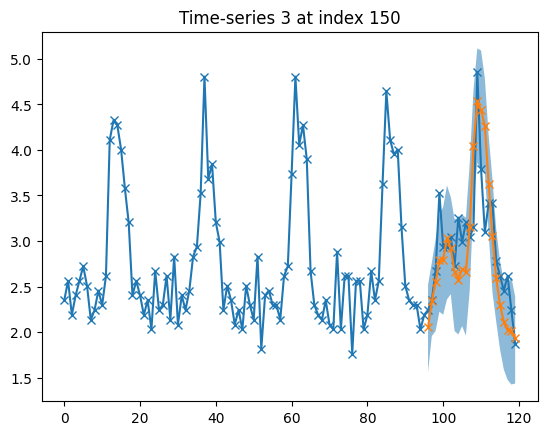

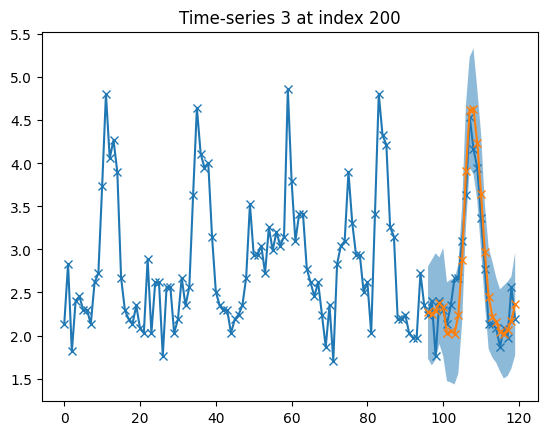

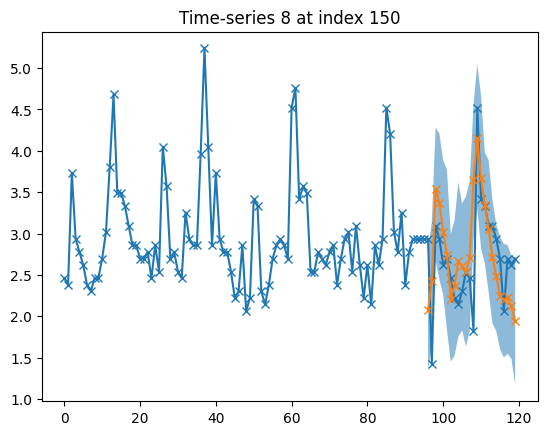

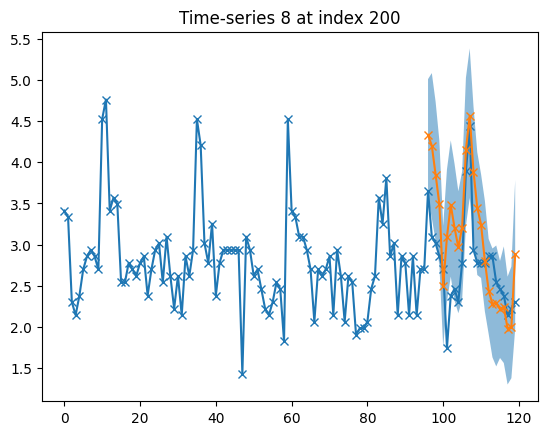

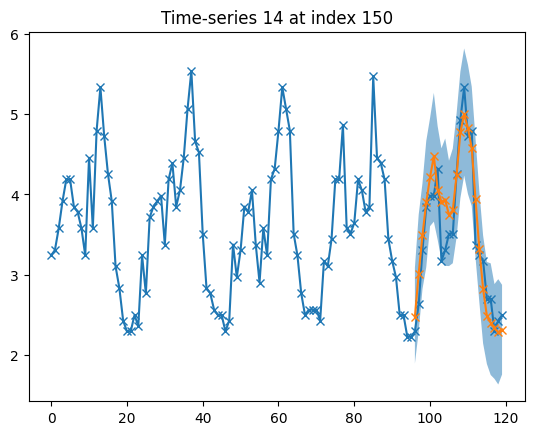

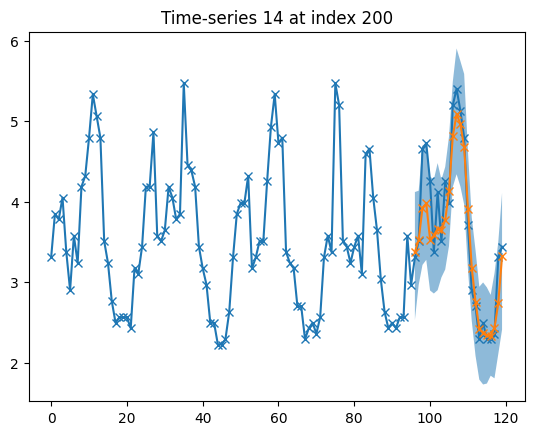

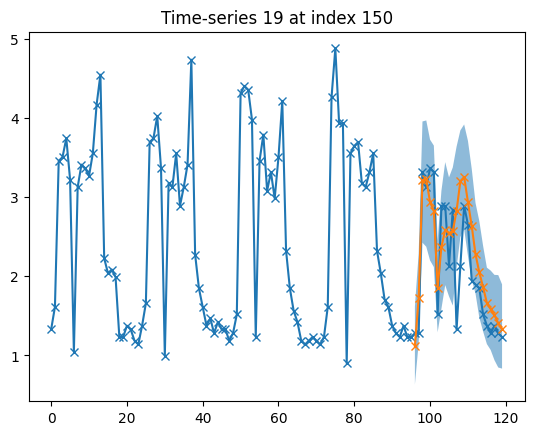

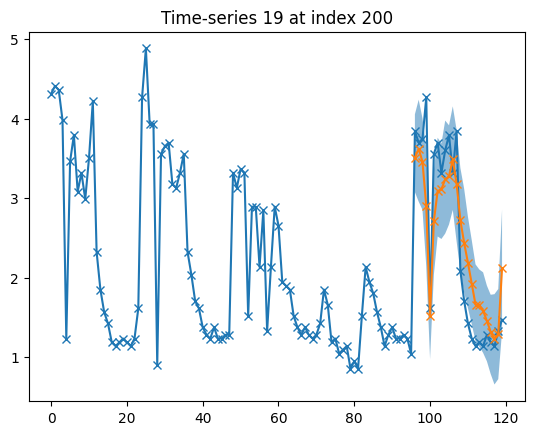

In [9]:
# Sample from model
indices = [150,200]

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)
samples = samples.cpu()

# Sort samples in ascending order
samples = samples.permute(0,2,3,1).flatten(start_dim=0,end_dim=2).sort()[0].reshape(samples.shape[0],samples.shape[2],samples.shape[3],-1).permute(0,3,1,2)

# Plot some predictions
confidence = 0.9
for ts, i in itertools.product([3,8,14,19],range(len(indices))):
    plt.figure()
    plt.title(f"Time-series {ts} at index {indices[i]}")
    plt.plot(test_dataset.tensor_data[indices[i]:indices[i]+context_length+prediction_length,ts],"-x")
    plt.plot(list(range(context_length,context_length+prediction_length)),torch.mean(samples[i,:,ts],dim = 0),"-x")
    plt.fill_between(list(range(context_length,context_length+prediction_length)), samples[i,int(confidence*samples.shape[1]),ts], samples[i,int((1-confidence)*samples.shape[1]),ts],alpha=0.5)
    #plt.savefig(f"images/no_shift_{idx}_{ts}.png")

In [10]:
# Make samples and extract realisations for last 14 days of test dataset
indices = list(range(0, 24*2, 24))

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)
samples = samples.cpu().numpy()


realisations = []
for idx in indices:
    realisations.append(
        test_data.values[context_length + idx:context_length + idx + prediction_length].T
    )
realisations = np.stack(realisations)


In [11]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=3) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

MSE: 0.2052503833510097 MAE: 0.3217202846525539 MDAE: 0.22998158118303713
CRPS_sum: 8.51425270239512 Variogram_score: 0.07106198107271981
